# Project description
You work for the online store Ice, which sells video games all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources. You need to identify patterns that determine whether a game succeeds or not. This will allow you to spot potential big winners and plan advertising campaigns.
In front of you is data going back to 2016. Let’s imagine that it’s December 2016 and you’re planning a campaign for 2017.

The dataset contains the abbreviation ESRB. The Entertainment Software Rating Board evaluates a game's content and assigns an age rating such as Teen or Mature.

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

df = pd.read_csv('games.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


# Prepare the data
## Assign more suitable column types

In [90]:
df.columns = df.columns.str.lower()

# Let's mark categorical columns with type 'category' for improved readability and performance
df['genre'] = df['genre'].astype('category')
df['platform'] = df['platform'].astype('category')
df['rating'] = df['rating'].astype('category')

# Let's mark the year of release as a datetime object. This will help us group dates properly. Otherwise we will have different year of release for values like 2016 and 2016.0
df['year_of_release'] = pd.to_datetime(df['year_of_release'], format='%Y')

# Let's mark the user score as a numeric object. It is not numeric because some missing scores are marked as 'tbd'. We can safely coerce these to NaN
df['user_score'] = pd.to_numeric(df['user_score'], errors='coerce')
df['user_score'] = df['user_score'] * 10 # We multiply user score by 10 so it has the same scale as critic score


## Work with missing values and duplicates

In [91]:
# we only have two games without a name. These do have some sales data, but nothing besides that. I don't think it's worth identifying what are these two games so let's just drop those
df = df.dropna(subset=['name'])

# there are 269 games without a year of release. But interestingly some of those games contain release year in their names. Let's try to extract that and assign a value to year_of_release column
year_from_name = df[df['year_of_release'].isnull()]['name'].str.extract(r'(\d{4})', expand=False)
year_from_name = pd.to_datetime(year_from_name, format='%Y')
df.loc[year_from_name.index, 'year_of_release'] = year_from_name

print(f"We still have {df['year_of_release'].isnull().sum()} games without a year of release") 

We still have 252 games without a year of release


We still have a lot of missing values for critis_score, user_score and rating. 
critic_score is likely missing because games that are not very popular are not reviewed by critics
user_score is likely missing for the old games, also games which were released on many platforms might not receive proper reviews for every platform. We could coerce such scores from other platforms, but that would not be really fair
rating is likely missing for the games which are not popular enough to be rated by ESRB

In [92]:
# We have one duplicate entry for Madden NFL 13. Duplicate only contains 0.01 sales in eu so let's drop it
df.drop(df[(df['name'] == 'Madden NFL 13') & (df['eu_sales'] == 0.01)].index, inplace=True)

df.duplicated(subset=['name', 'platform', 'year_of_release']).sum()

0

Now we don't have any duplicate entries.
## Add total_sales column

In [93]:

df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16712 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   name             16712 non-null  object        
 1   platform         16712 non-null  category      
 2   year_of_release  16460 non-null  datetime64[ns]
 3   genre            16712 non-null  category      
 4   na_sales         16712 non-null  float64       
 5   eu_sales         16712 non-null  float64       
 6   jp_sales         16712 non-null  float64       
 7   other_sales      16712 non-null  float64       
 8   critic_score     8136 non-null   float64       
 9   user_score       7589 non-null   float64       
 10  rating           9948 non-null   category      
 11  total_sales      16712 non-null  float64       
dtypes: category(3), datetime64[ns](1), float64(7), object(1)
memory usage: 1.3+ MB


# Analyze the data

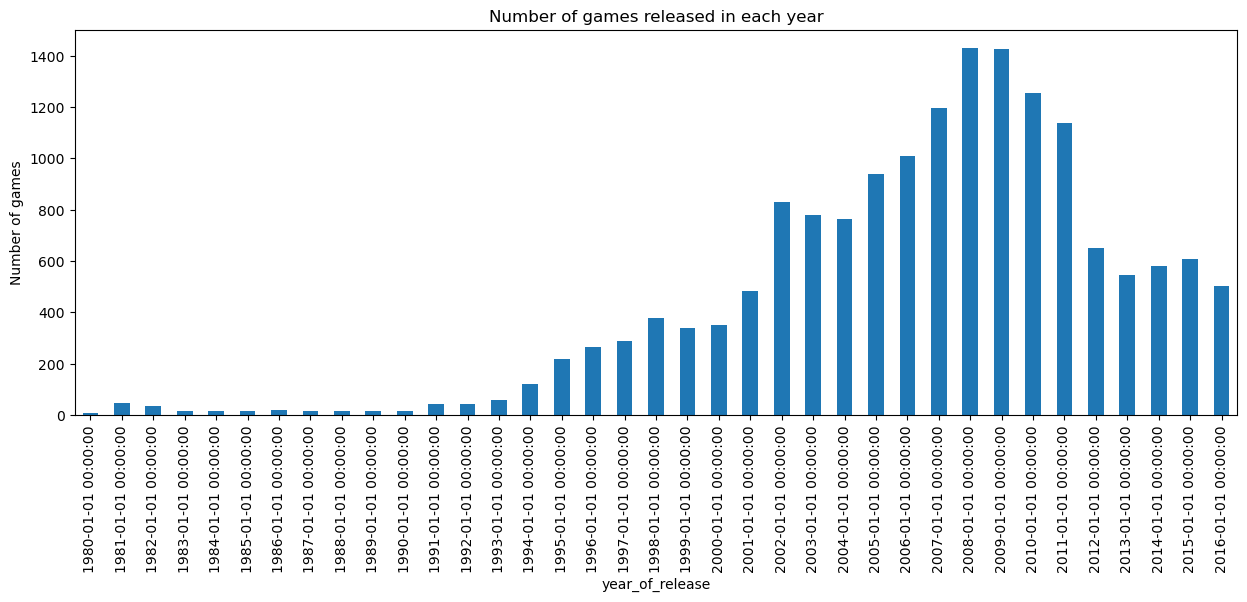

In [95]:
# plot number of games released in each year
df.groupby('year_of_release')['name'].count().plot(kind='bar', figsize=(15, 5))
plt.title('Number of games released in each year')
plt.ylabel('Number of games')
plt.show()


We have very little data on games prior to 1993. But I don't think that we should drop it or do something with it. There just weren't as many games back then.  Golden age of video gaming was around 2008-2010. 

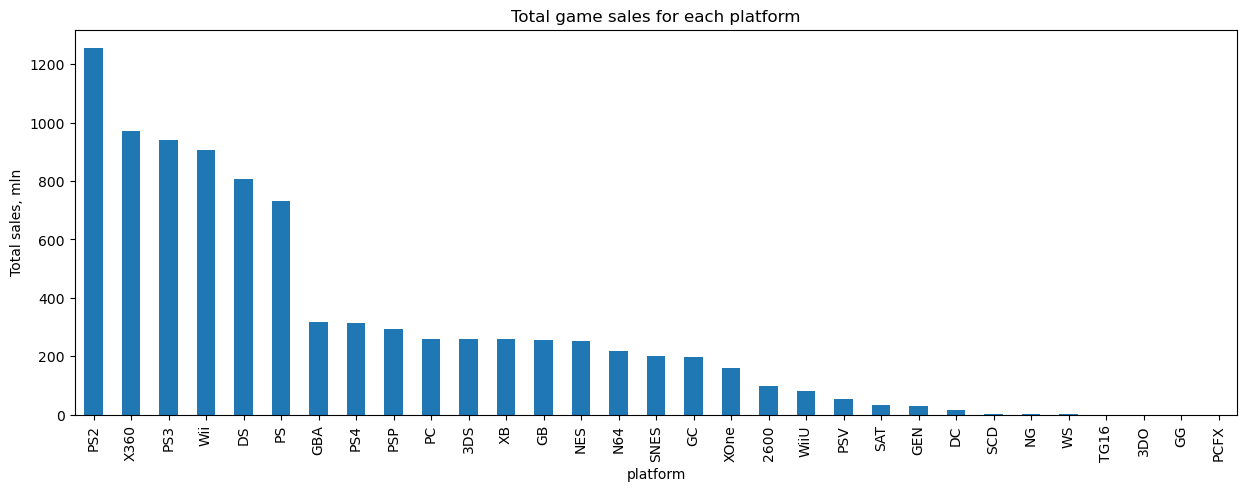

In [96]:
total_sales_by_platform = df.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
total_sales_by_platform.plot(kind='bar', figsize=(15, 5))
plt.title('Total game sales for each platform')
plt.ylabel('Total sales, mln')
plt.show()

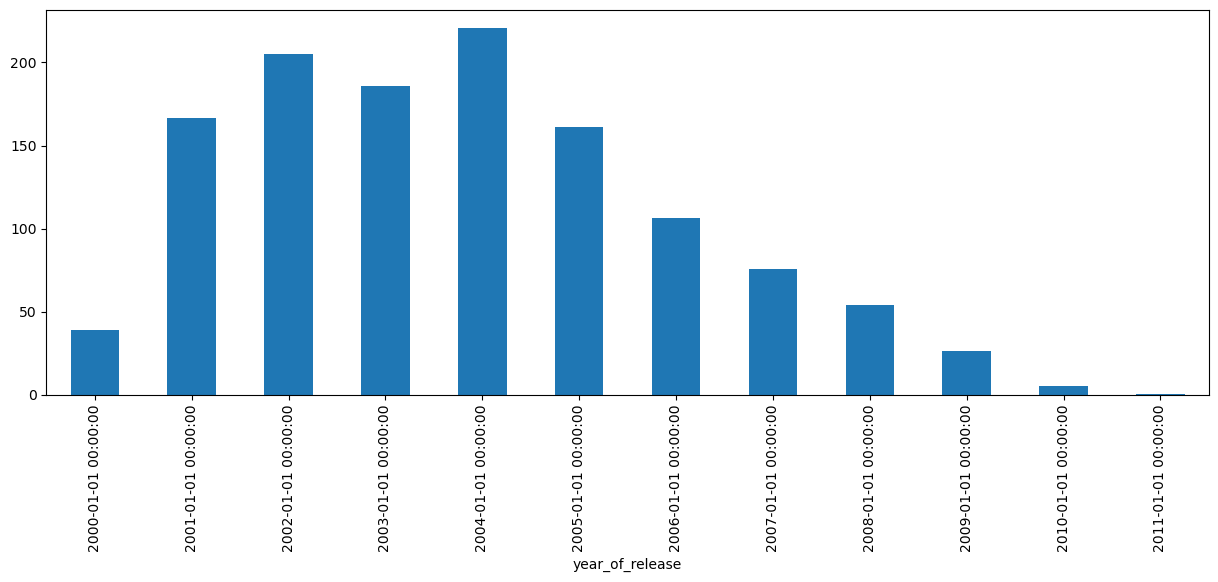

In [97]:
df[df['platform'] == 'PS2'].groupby('year_of_release')['total_sales'].sum().plot(kind='bar', figsize=(15, 5))
plt.show()

In [98]:
print(f"Mean amount of years each platform lives is {df.groupby('platform')['year_of_release'].nunique().mean()}")


Mean amount of years each platform lives is 7.67741935483871


In [99]:
top_selling_platforms = df[df['platform'].isin(total_sales_by_platform.index[:10])].groupby('platform')['year_of_release'].nunique()

print('Number of years each platform lives:')
top_selling_platforms[top_selling_platforms > 0].sort_values(ascending=False)


Number of years each platform lives:


platform
PC      26
PS2     12
PSP     12
X360    12
DS      11
PS3     11
Wii     11
PS      10
GBA      8
PS4      4
Name: year_of_release, dtype: int64

Since we want to make a prediction for 2017 and top platforms exist for around 11 years, and our data is most valuable starting from around 2002 we will take data from 2006 to 2016 for our analysis. However this way we will likely match some trends which are no longer representing the market. So the wiser option would be to take a smaller period of 2 years and make a forecast with it. This way we will not miss platforms that are on the rise and we will not be biased by some old trends in gaming


In [100]:
df = df[df['year_of_release'] >= pd.to_datetime('2014', format='%Y')]
df['platform'] = (df['platform'].astype('string')).astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 31 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   name             1689 non-null   object        
 1   platform         1689 non-null   category      
 2   year_of_release  1689 non-null   datetime64[ns]
 3   genre            1689 non-null   category      
 4   na_sales         1689 non-null   float64       
 5   eu_sales         1689 non-null   float64       
 6   jp_sales         1689 non-null   float64       
 7   other_sales      1689 non-null   float64       
 8   critic_score     718 non-null    float64       
 9   user_score       888 non-null    float64       
 10  rating           940 non-null    category      
 11  total_sales      1689 non-null   float64       
dtypes: category(3), datetime64[ns](1), float64(7), object(1)
memory usage: 138.0+ KB


Quality of our dataset has improved! We now have year_of_release for all games, which will help us make a more accurate prediction

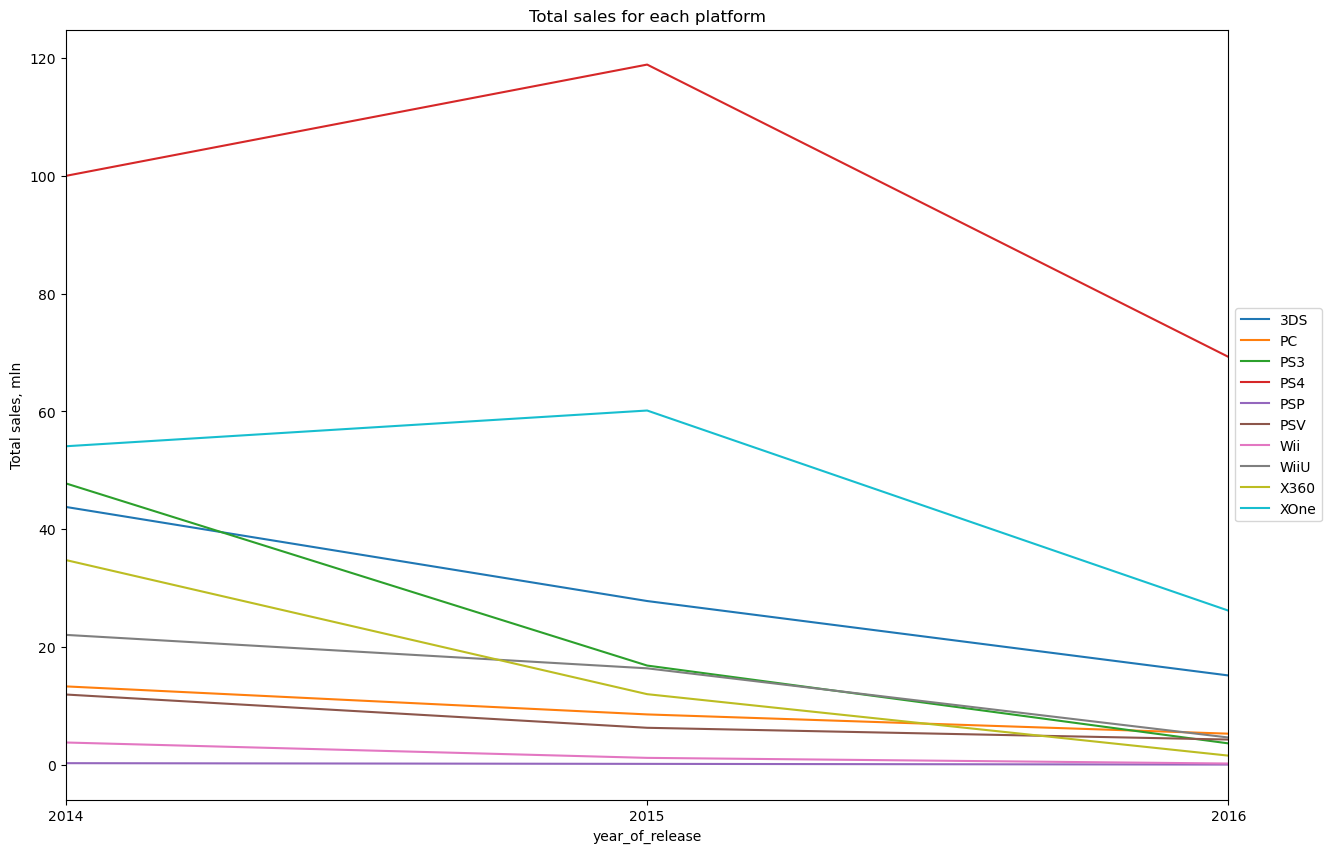

In [101]:
df.groupby(['year_of_release', 'platform'])['total_sales'].sum().unstack().plot(kind='line', figsize=(15, 10))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Total sales for each platform')
plt.ylabel('Total sales, mln')
plt.show()


In [102]:
platform_sales_2016 = df[df['year_of_release'] == pd.to_datetime('2016', format='%Y')].groupby('platform')['total_sales'].sum().sort_values(ascending=False)
platform_sales_2016[platform_sales_2016 > 0]

platform
PS4     69.25
XOne    26.15
3DS     15.14
PC       5.25
WiiU     4.60
PSV      4.25
PS3      3.60
X360     1.52
Wii      0.18
Name: total_sales, dtype: float64

Current top sellers are:
- PS4 
- XOne
- 3DS

PS4 and XOne are the most recent platforms, so they are likely to be the most popular in 2017 - for both platforms it's the peak of their lifespan, each platform is 4 years old. In our current data we see decline in sales in 2016 but that might be also due to the fact that the data is incomplete. 3DS is 7 years old and been steadily declining in sales for the last 4 years.

The only other platform that might be worth considering is PC - even though it sells 3 times less than 3DS this platform is unique in the fact that it was around throughout all gaming history. It's also the only platform that is not a console, so it's not tied to a specific manufacturer.

All other platform sales are declining - WiiU, PSV, PS3, X360, Wii are all too old. WiiU is the yongest among them but it's still 5 years old and it's sales are declining from 2013.

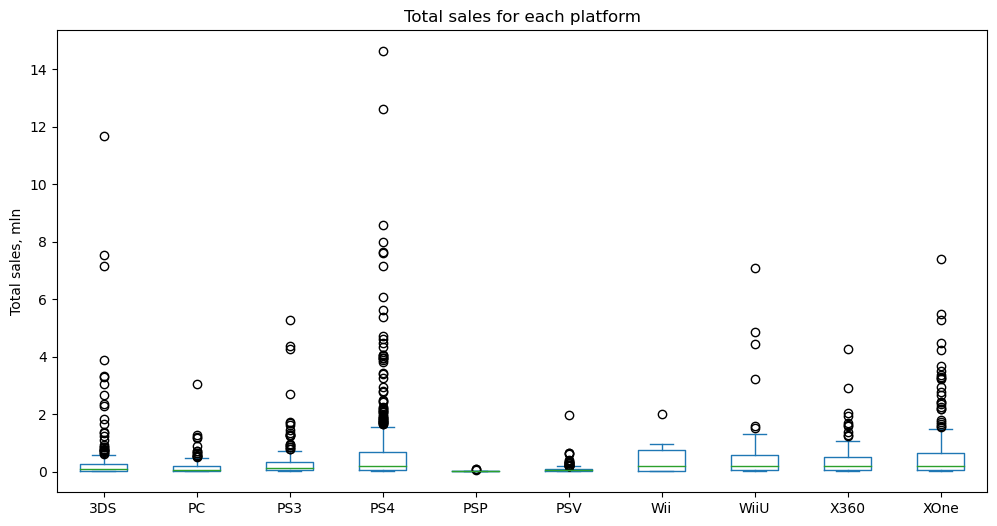

In [103]:
total_sales_by_platform_boxplot = df.plot(kind='box', column='total_sales', by='platform', figsize=(12, 6))
plt.title('Total sales for each platform')
plt.ylabel('Total sales, mln')
plt.show()

There are tons of outlies in games sales. There are very few games that sell more than 2 million copies. Let's zoom in and see how good is an average game selling.

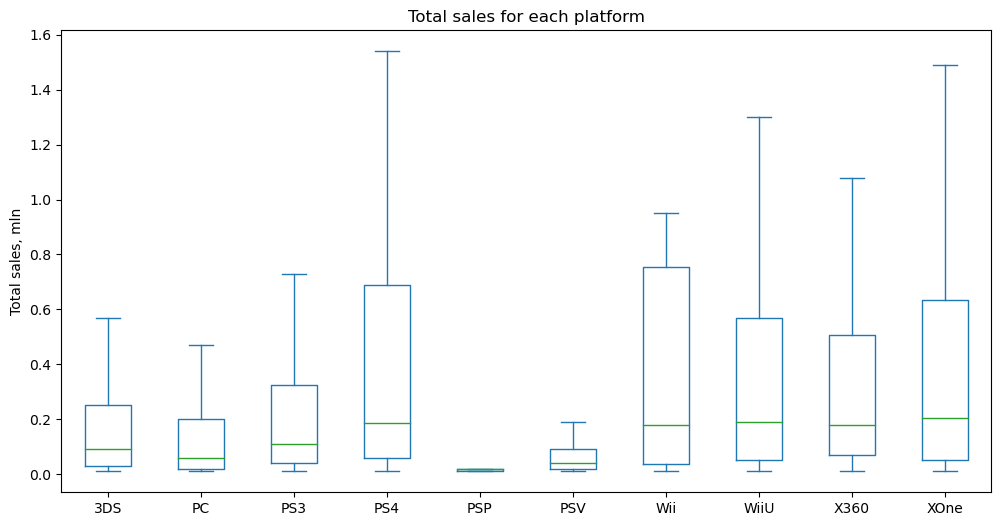

In [104]:
df.plot(kind='box', column='total_sales', by='platform', figsize=(12, 6), showfliers=False)
plt.title('Total sales for each platform')
plt.ylabel('Total sales, mln')
plt.show()

We can see that differences in sales for each platform are pretty significant. But still most of the average games will sell 0.03 to 0.75 million copies on a given platform.

This is skewed to lower values for less popular platforms. 3DS might sell 0.05 to 0.3 million copies for their top 25-75% games. Same for  PS3 (which is a dying platform), which sell just a little bit less for their average games - around 0.25 million copies.

Leading platforms here are PS4, Wii and XOne might have a better overall quality of games so the average game on the platform might sell around 0.25 million copies.

For the PC this number is much lower - 0.05 million copies. This is most likely due to the fact that releasing a game for PC is much easier.

### Let's see how user and professional reviews affect sales for one of the top selling platforms

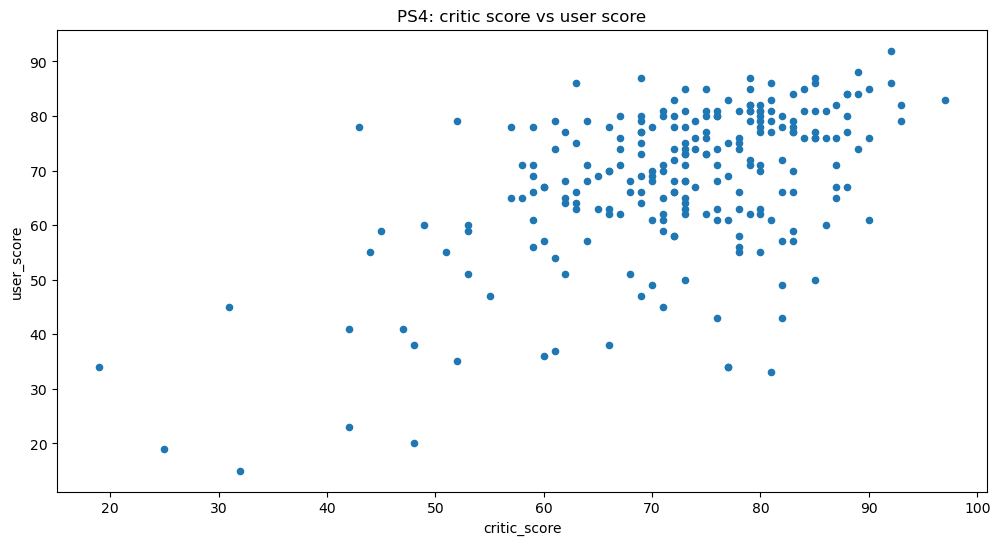

In [105]:
ps4df = df[df['platform'] == 'PS4']

ps4df.plot(kind='scatter', x='critic_score', y='user_score', figsize=(12, 6))
plt.title('PS4: critic score vs user score')
plt.show()


In [106]:
ps4df['critic_score'].corr(ps4df['user_score'])

0.546434245119031

User score has an average positive correlation with critic score on ps4

In [107]:
print(f"PS4 correlation between critic score and total sales is {ps4df['critic_score'].corr(ps4df['total_sales'])}")
print(f"PS4 correlation between user score and total sales is {ps4df['user_score'].corr(ps4df['total_sales'])}")

PS4 correlation between critic score and total sales is 0.40266141068104083
PS4 correlation between user score and total sales is -0.04013158947269736


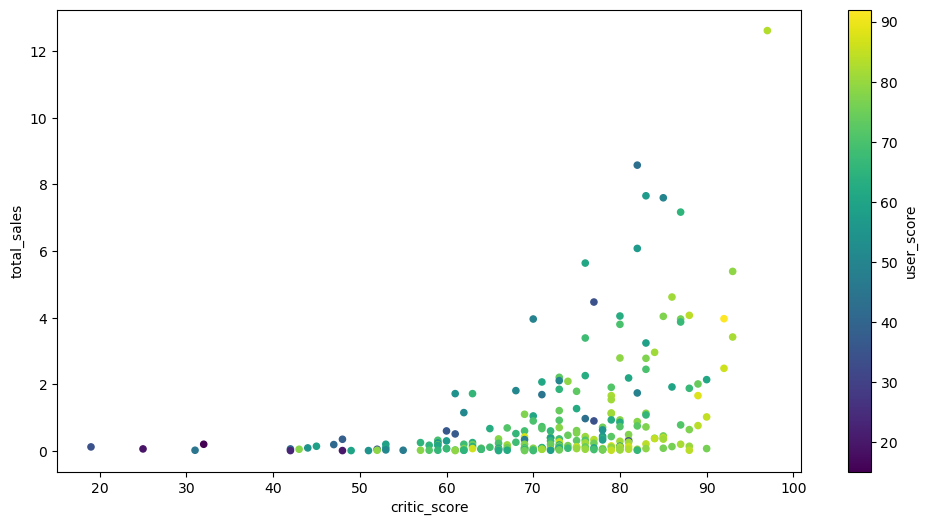

In [108]:
ps4df.plot(kind='scatter', x='critic_score', y='total_sales', c='user_score', figsize=(12, 6))
plt.show()


However both of those are not very good predictors of total sales. User score has almost no correlation to total sales. Critic score has a mild positive correlation

In [109]:
corr_for_platform_df = pd.DataFrame(columns=['platform', 'critic_score_user_score_corr', 'critic_score_total_sales_corr', 'user_score_total_sales_corr'])

for platform in df['platform'].unique():
    platformdf = df[df['platform'] == platform].query('critic_score > 0 & user_score > 0')
    if (len(platformdf) < 10): # exclude platforms with low amount of scored games
        continue
    corr_for_platform_df = pd.concat(
        [
            corr_for_platform_df,
            pd.DataFrame(
                [[
                    platform,
                    platformdf['critic_score'].corr(platformdf['user_score']),
                    platformdf['critic_score'].corr(platformdf['total_sales']),
                    platformdf['user_score'].corr(platformdf['total_sales'])
                ]],
                columns=['platform', 'critic_score_user_score_corr', 'critic_score_total_sales_corr', 'user_score_total_sales_corr']
            )
        ]
    )

corr_for_platform_df.groupby('platform').mean().sort_values(by='critic_score_total_sales_corr', ascending=False)


,critic_score_user_score_corr,critic_score_total_sales_corr,user_score_total_sales_corr
platform,,,
X360,0.625309,0.525723,0.336514
PS3,0.693445,0.446575,0.156595
XOne,0.440977,0.422112,-0.091734
PS4,0.546434,0.401903,-0.043186
WiiU,0.763536,0.375640,0.411451
3DS,0.862485,0.284686,0.279850
PC,0.466099,0.172061,-0.089974
PSV,0.524066,0.041029,0.023528


User score has a mild positive correlation on X360, WiiU and 3DS. It has almost no correlation with sales on other platforms

Critic score is a much better predictor of total sales. On all platofrms it has a 0.17 (PC) to 0.52 (X360) correlation which is a good predictor of sales.

### Game genre and sales

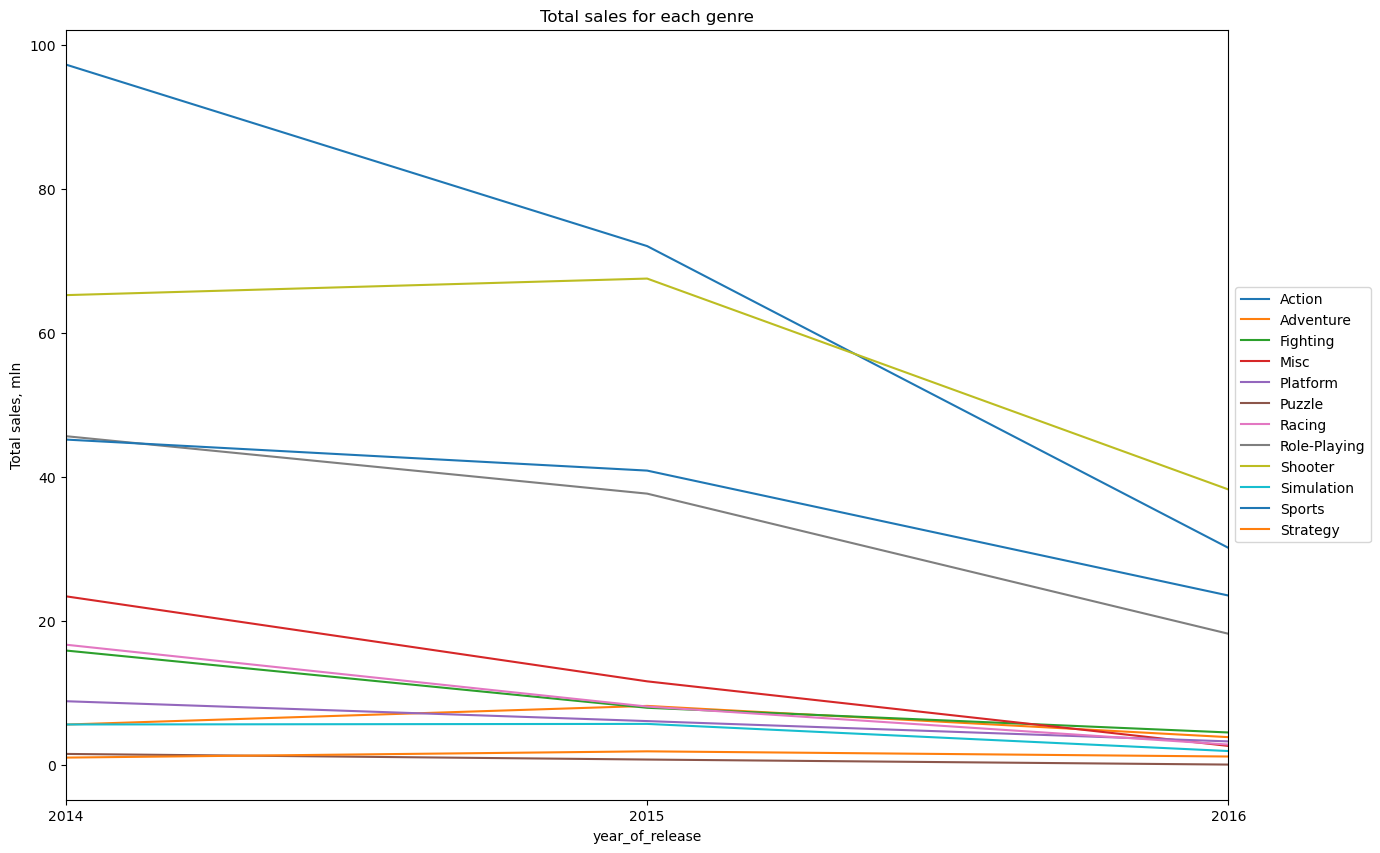

In [110]:
df.groupby(['year_of_release', 'genre'])['total_sales'].sum().unstack().plot(kind='line', figsize=(15, 10))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Total sales for each genre')
plt.ylabel('Total sales, mln')
plt.show()

In [111]:
df.pivot_table(index='year_of_release', columns='genre', values='total_sales', aggfunc='sum')
df.groupby(['year_of_release', 'genre'])['total_sales'].sum().unstack()

genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
year_of_release,,,,,,,,,,,,
2014-01-01,97.23,5.57,15.85,23.38,8.81,1.49,16.66,45.62,65.21,5.58,45.15,0.98
2015-01-01,72.02,8.16,7.90,11.57,6.05,0.71,8.07,37.64,67.51,5.66,40.84,1.85
2016-01-01,30.11,3.82,4.47,2.60,3.23,0.01,2.79,18.18,38.22,1.89,23.49,1.13


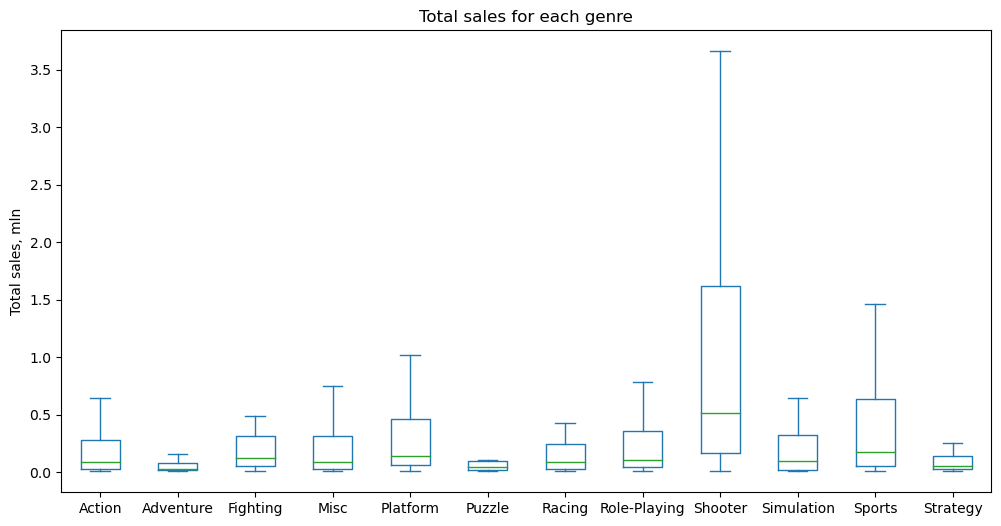

In [112]:
# make a box plot of total sales for each genre
df.plot(kind='box', column='total_sales', by='genre', showfliers=False, figsize=(12, 6))
plt.title('Total sales for each genre')
plt.ylabel('Total sales, mln')
plt.show()


### In total:
Most profitable game genres throughout last years are Action, Shooter, Sports, Role-Playing.
Action was leading all previous years but in 2016 Shooter is the most profitable genre.

The least profitable game genres are Puzzle, Strategy and Simulation

### Average game
Shooters are selling like hot cakes with  a 25-75% laying in the range 0.1 to 1.5 mls total sales.
Sports and platform games are a little bit behind with 0.1 to 0.5 total sales in a box range.

Games that sell the worst are Adventure, Puzzle and Strategy

# User profile for each region

In [113]:
region_sales_columns = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
platform_sales_df = df.groupby('platform')[region_sales_columns].sum() 

print('Top 5 platforms by sales in each region:')
for region in region_sales_columns:
    print(platform_sales_df[region].sort_values(ascending=False).head(5))

Top 5 platforms by sales in each region:
platform
PS4     98.61
XOne    81.27
X360    28.30
3DS     22.64
PS3     22.05
Name: na_sales, dtype: float64
platform
PS4     130.04
XOne     46.25
PS3      25.54
PC       17.97
3DS      16.12
Name: eu_sales, dtype: float64
platform
3DS     44.24
PS4     15.02
PSV     14.54
PS3     11.22
WiiU     7.31
Name: jp_sales, dtype: float64
platform
PS4     44.48
XOne    12.52
PS3      9.37
X360     4.35
3DS      3.68
Name: other_sales, dtype: float64


All over the world PS4 is leading in sales, besides Japan where 3DS is leading. Japan market here is very different from data in other regions. 
THe other notable thing is that X360 still has a pretty good sales in North America but is dead everywhere else. But considering the fact that the platform is old, we will definitely see a decrease in sales for that platform in the following years.

In [114]:
genre_sales_df = df.groupby('genre')[region_sales_columns].sum()

print('Top 5 genres by sales in each region:')
for region in region_sales_columns:
    print(genre_sales_df[region].sort_values(ascending=False).head(5))
    

Top 5 genres by sales in each region:
genre
Shooter         79.02
Action          72.53
Sports          46.13
Role-Playing    33.47
Misc            15.05
Name: na_sales, dtype: float64
genre
Action          74.68
Shooter         65.52
Sports          45.73
Role-Playing    28.17
Racing          14.13
Name: eu_sales, dtype: float64
genre
Role-Playing    31.16
Action          29.58
Fighting         6.37
Misc             5.61
Shooter          4.87
Name: jp_sales, dtype: float64
genre
Action          22.57
Shooter         21.53
Sports          14.36
Role-Playing     8.64
Misc             4.03
Name: other_sales, dtype: float64


Here japan market is very different too - people like Role-Playing, Action and Misc games much more than other ones. Other than that the whole world is mostly aggreeing on most popular genres. These are Action, Shooter and Sports.

In [115]:
esrb_sales_df = df.groupby('rating')[region_sales_columns].sum()

print('Top 3 selling esrb ratings in each region:')
for region in region_sales_columns:
    print(esrb_sales_df[region].sort_values(ascending=False).head(3))


Top 3 selling esrb ratings in each region:
rating
M    96.42
E    50.74
T    38.95
Name: na_sales, dtype: float64
rating
M    93.44
E    58.06
T    34.07
Name: eu_sales, dtype: float64
rating
T    14.78
E     8.94
M     8.01
Name: jp_sales, dtype: float64
rating
M    28.67
E    15.39
T    11.33
Name: other_sales, dtype: float64


The whole world loves games rated M (Mature) and E (Everyone). Japan is the only region where T games are more popular. We again see a cultural difference here. Seems that ESRB rating affect game sales in Japan a lot

# Testing hypothesis

### Test that the average user ratings of the Xbox One and PC platforms are the same.
Null hypothesis is that these are the same. Alternative hypothesis is that they are not.
We pick alpha value of 0.05 as it is a common value for such tests and it gives a pretty good precision when we use it.

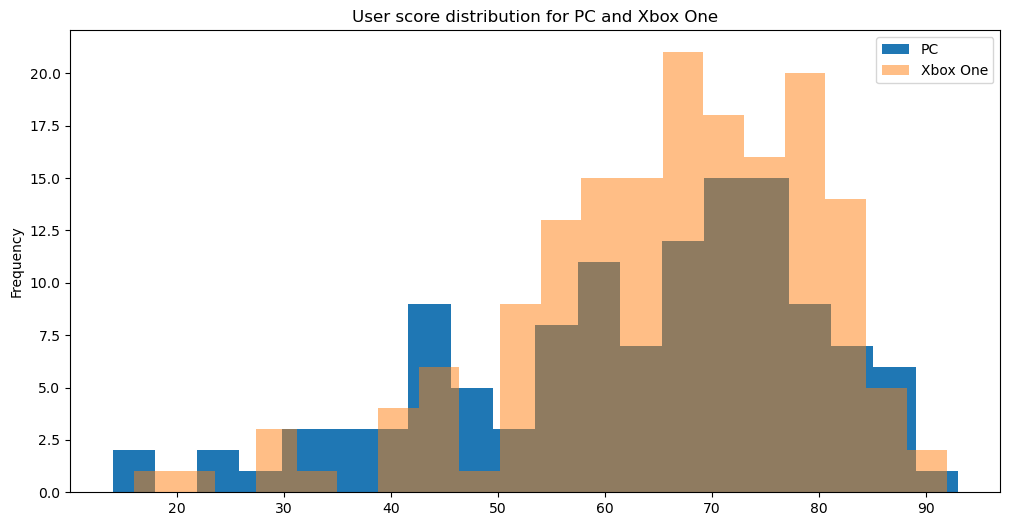

In [116]:
xbox_one_df = df[df['platform'] == 'XOne']
pc_df = df[df['platform'] == 'PC']

pc_df['user_score'].plot(kind='hist', bins=20, figsize=(12, 6))
xbox_one_df['user_score'].plot(kind='hist', bins=20, alpha=0.5)
plt.legend(['PC', 'Xbox One'])
plt.title('User score distribution for PC and Xbox One')
plt.show()

In [117]:
xbox_pc_ttest_ind = st.ttest_ind(xbox_one_df['user_score'], pc_df['user_score'], equal_var=False, nan_policy='omit')

alpha = 0.05

print(f"p-value for Xbox One vs PC user score distribution is {xbox_pc_ttest_ind.pvalue}")
if (xbox_pc_ttest_ind.pvalue < alpha):
    print('We reject the null hypothesis that user score on these platofrms are equal')
else:
    print('We cant reject the null hypothesis that user score on these platforms are equal')

p-value for Xbox One vs PC user score distribution is 0.11601398086668921
We cant reject the null hypothesis that user score on these platforms are equal


We cant say that PC and Xbox One user scores are different. Both hist graph and independent t-test show that the difference in the scores is not statistically significant.

### Test that average user ratings for the Action and Sports genres are different

Our null hypothesis is that action and sports games have the same user ratings. Alternative hypothesis is that they are different.

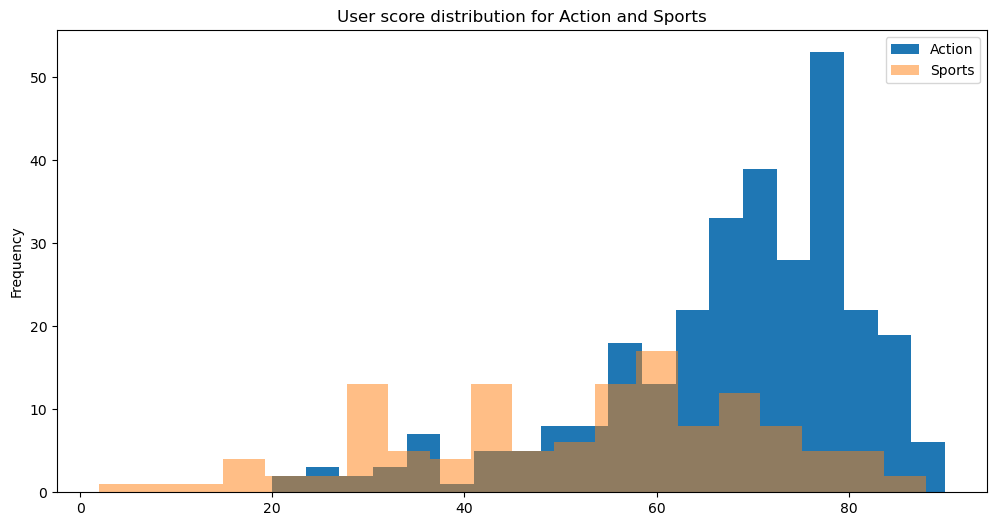

In [118]:
action_df = df[df['genre'] == 'Action']
sports_df = df[df['genre'] == 'Sports']

action_df['user_score'].plot(kind='hist', bins=20, figsize=(12, 6))
sports_df['user_score'].plot(kind='hist', bins=20, alpha=0.5)
plt.legend(['Action', 'Sports'])
plt.title('User score distribution for Action and Sports')
plt.show()


In [119]:
action_sports_ttest_ind = st.ttest_ind(action_df['user_score'], sports_df['user_score'], equal_var=False, nan_policy='omit')

alpha = 0.05

print(f"p-value for Action vs Sports user score distribution is {action_sports_ttest_ind.pvalue}")
if (action_sports_ttest_ind.pvalue < alpha):
    print('We reject the null hypothesis that user score for Action and Sports are equal')
else:
    print('We cant reject the null hypothesis that user score for Action and Sports are equal')

p-value for Action vs Sports user score distribution is 1.182555038264477e-14
We reject the null hypothesis that user score for Action and Sports are equal


For some reason average user score is very different for action and sports games. Action games are rated much higher on average, while sports ratings are all over the place.

We can now say that average user ratings for the Action and Sports genres are different

# General conclusion

### Recommendations for the whole world of gaming in 2017
Game market has about the same size in the last few years. It's not a golden age of gaming which  was around 2006-2008 but it still holds up pretty good.

The best platforms to develop games for and sell are PS4, XOne. PS4 and XOne will be at the pick of their popularity. PC is also a stable platform that has been around for as long as gaming is but it's sales are not as good as consoles.

Current trend in genre seems to be Shooter. It's the most popular one. Action, Sports and Platofrm do also have a good amount of sales on average and in total on the market. So if we want to make a game we should probably pick one of these genre.

When advertising a game it seems that critics are the ones we should please, not the users, especially if we are targeting most popular platforms. Critic score is much more indicative of how well a game sales.

User score can be ignored for the most part. They only play a role in WiiU and PS3, but these platofrms are old and should probably be avoided. 

ESRB rating is also does not seem to affect how well a game sells - sellings will be about equal all over the world.

### Note on Japan market
Japan market is very different from the rest of the world. It's the only region where T games are more popular than E games. It's also the only region where Role-Playing games are the most popular genre. 3DS is also the most popular platform here.

What we can say about Japan market in general is that it prefers local companies which make games for the whole world (Sony and Nintendo). It has different taste for genre and esrb rating. If we develop a game specifically for Japan market we should probably make it a Role-Playing game and target T rating. Something like Final Fantasy or Kingdom Hearts.



